<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 71 (delta 21), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (71/71), done.
ldpc_ber_18_11.png  project  sample_data
MainModel.ipynb       MainModelOneHotMethod.ipynb	    README.md
MainModelKeras.ipynb  MainModelWithSingleBERTraining.ipynb  util.py


In [18]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [19]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [20]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [21]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 1 1 ... 0 0 0]
 [0 1 1 ... 0 1 0]
 [0 0 1 ... 1 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 1 1 1]
 [0 0 0 ... 1 0 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [22]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.67s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.36s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.90s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.56s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 16.49s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.69s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.89s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.12s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 13.02s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.22s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.34s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.50s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.69s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 11.74s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.90s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.99s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [23]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.48s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.00s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.52s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.02s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 15.03s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.57s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.77s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.96s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 12.61s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.17s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.08s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.21s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.20s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 10.65s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.78s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.64s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [24]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.47s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.99s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.41s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.00s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 14.86s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.38s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.67s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.96s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.19s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 13.21s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.18s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.21s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.23s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 10.70s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.81s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.53s
SNR: 1.500 - Iter: 750 - Last 250.0 it

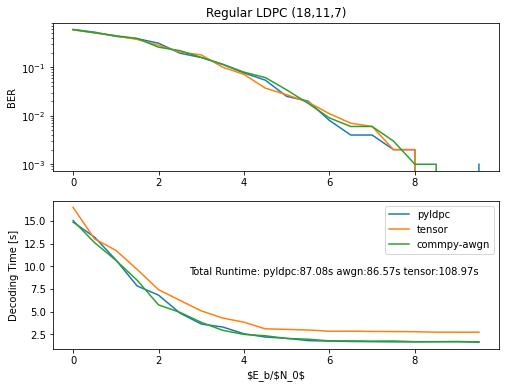

In [25]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [26]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=0.00007).minimize (loss1)
rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=0.001).minimize (loss1)

input_message_length= 11


In [27]:
batch_size = 500
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 60
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1

for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    if (snr < 6): opt = rms_optimizer1
    else : opt = rms_optimizer 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.0001
        if j % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))

[[1 1 1 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 1 1]
 ...
 [1 1 0 ... 0 0 1]
 [0 0 0 ... 1 0 1]
 [0 1 1 ... 0 1 0]]
10000
batch_size: 500 num_of_batcches: 20.0
Training for SNR= 0.0  sigma= 1.0
Step 29970: Minibatch Loss: 1.054910
Step 29970: Minibatch Loss: 1.005114
Step 29970: Minibatch Loss: 0.935961
Step 29970: Minibatch Loss: 0.900859
Step 29970: Minibatch Loss: 0.863855
Step 29970: Minibatch Loss: 0.832633
Step 29970: Minibatch Loss: 0.805186
Step 29970: Minibatch Loss: 0.778202
Step 29970: Minibatch Loss: 0.765360
Step 29970: Minibatch Loss: 0.733686
Step 29970: Minibatch Loss: 0.723976
Step 29970: Minibatch Loss: 0.708329
Step 29970: Minibatch Loss: 0.687636
Step 29970: Minibatch Loss: 0.671480
Step 29970: Minibatch Loss: 0.653893
Step 29970: Minibatch Loss: 0.642243
Step 29970: Minibatch Loss: 0.638251
Step 29970: Minibatch Loss: 0.618522
Step 29970: Minibatch Loss: 0.617014
Step 29970: Minibatch Loss: 0.610801
Step 29970: Minibatch Loss: 0.587934
Step 29970: Minibatch Los

In [28]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.81s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.07s
SNR: 0.000:
 -> BER: 0.69
 -> Total Time: 2.73s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.02s
SNR: 0.500:
 -> BER: 0.66
 -> Total Time: 2.54s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.02s
SNR: 1.000:
 -> BER: 0.60
 -> Total Time: 2.52s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

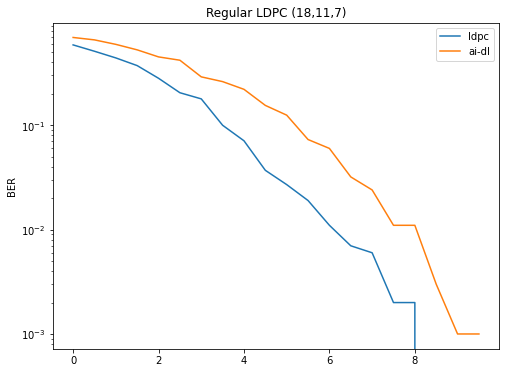

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [30]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


In [31]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.03s
SNR: 0.000:
 -> BER: 0.70
 -> Total Time: 2.57s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.75s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 0.500:
 -> BER: 0.67
 -> Total Time: 2.51s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.01s
SNR: 1.000:
 -> BER: 0.58
 -> Total Time: 2.54s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

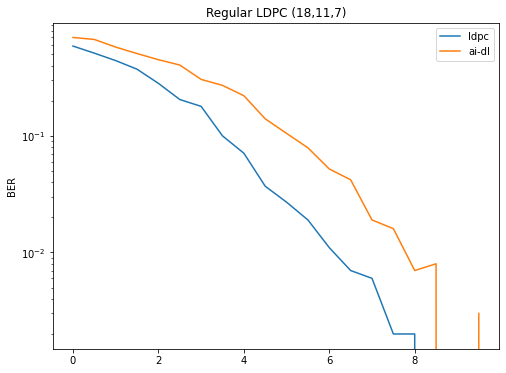

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()